# Bike Rent - Predict demand

Importing libraries

In [253]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

plt.style.use('dark_background')

import warnings
warnings.simplefilter('ignore')


Loading preprocessed dataset and transforming column of date to datetime

In [254]:
og = pd.read_csv('../data/processed/SeoulBikeDataEDA.csv', encoding='cp1252')
df = og.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df

,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,WeekDay,WeekDayEncoding,IsWeekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,0.0,0.0,0.0,Autumn,0,1,2018,11,30,Friday,5,0
8756,2018-11-30,764,20,3.4,37,2.3,2000,0.0,0.0,0.0,Autumn,0,1,2018,11,30,Friday,5,0
8757,2018-11-30,694,21,2.6,39,0.3,1968,0.0,0.0,0.0,Autumn,0,1,2018,11,30,Friday,5,0
8758,2018-11-30,712,22,2.1,41,1.0,1859,0.0,0.0,0.0,Autumn,0,1,2018,11,30,Friday,5,0


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     8760 non-null   datetime64[ns]
 1   Rented Bike Count        8760 non-null   int64         
 2   Hour                     8760 non-null   int64         
 3   Temperature(Â°C)         8760 non-null   float64       
 4   Humidity(%)              8760 non-null   int64         
 5   Wind speed (m/s)         8760 non-null   float64       
 6   Visibility (10m)         8760 non-null   int64         
 7   Solar Radiation (MJ/m2)  8760 non-null   float64       
 8   Rainfall(mm)             8760 non-null   float64       
 9   Snowfall (cm)            8760 non-null   float64       
 10  Seasons                  8760 non-null   object        
 11  Holiday                  8760 non-null   int64         
 12  Functioning Day          8760 non-

Will create another dataset just with days that were possible to rent a bike (Functioning Day = 1)

In [256]:
work = df[df['Functioning Day'] == 1]
work.drop('Functioning Day', inplace=True, axis=1)


In [257]:
work.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8465.0,729.156999,642.351166,2.0,214.0,542.00,1084.00,3556.00
Hour,8465.0,11.507029,6.920899,0.0,6.0,12.00,18.00,23.00
Temperature(Â°C),8465.0,12.771057,12.104375,-17.8,3.0,13.50,22.70,39.40
Humidity(%),8465.0,58.147194,20.484839,0.0,42.0,57.00,74.00,98.00
Wind speed (m/s),8465.0,1.725883,1.034281,0.0,0.9,1.50,2.30,7.40
Visibility (10m),8465.0,1433.873479,609.051229,27.0,935.0,1690.00,2000.00,2000.00
Solar Radiation (MJ/m2),8465.0,0.567868,0.868245,0.0,0.0,0.01,0.93,3.52
Rainfall(mm),8465.0,0.149120,1.125540,0.0,0.0,0.00,0.00,35.00
Snowfall (cm),8465.0,0.077685,0.444063,0.0,0.0,0.00,0.00,8.80
Holiday,8465.0,0.048198,0.214198,0.0,0.0,0.00,0.00,1.00


### Target feature


Looks like our target is a little skewed to the right. Let's check!


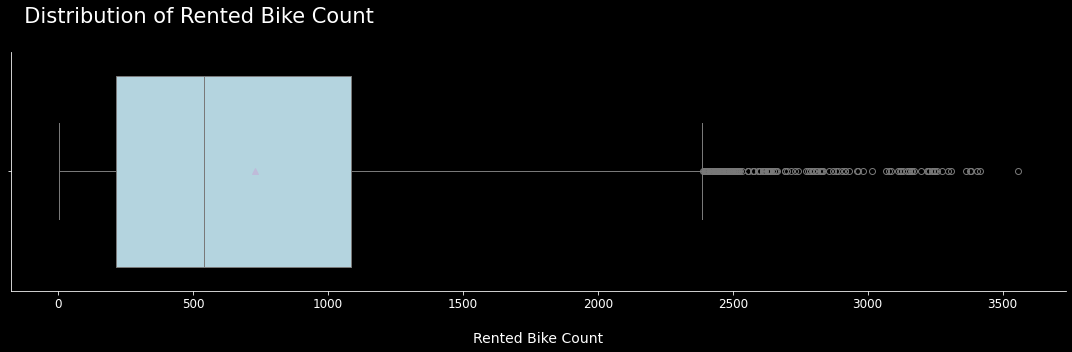

In [258]:
plt.figure(figsize=(15, 5)) 
sns.boxplot(
    data=work,
    x='Rented Bike Count',
    orient='h',
    showmeans=True,
    color='lightblue',
)

sns.despine(right=True)
plt.xlabel('\nRented Bike Count', fontsize=14)
plt.title('  Distribution of Rented Bike Count\n', fontsize=21, loc='left')
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

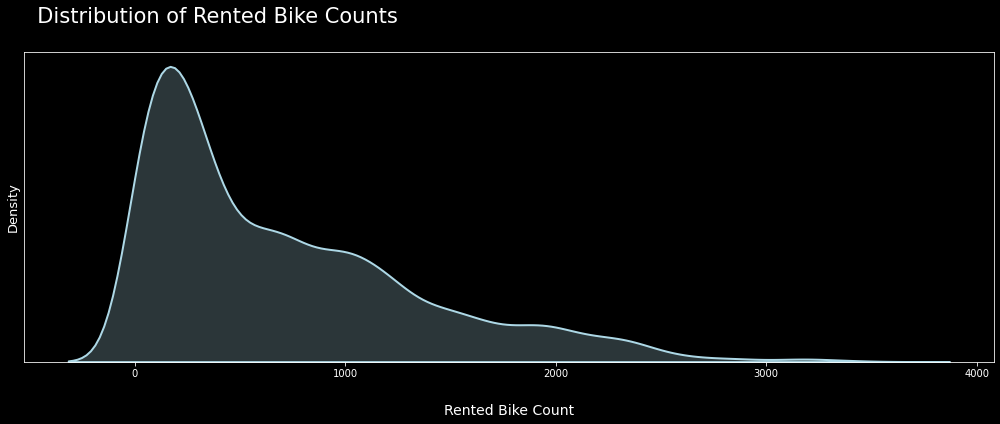

In [259]:
plt.figure(figsize=(14, 6))
sns.kdeplot(data=df['Rented Bike Count'], color='lightblue', linewidth=2, fill=True)
plt.xlabel('\nRented Bike Count', labelpad=8, fontsize=14)
plt.title('  Distribution of Rented Bike Counts\n', fontsize=21, loc='left')
plt.ylabel('Density', fontsize=13)
plt.yticks([])
plt.tight_layout()
plt.show()

Let's find the linear correlation between the features with a heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

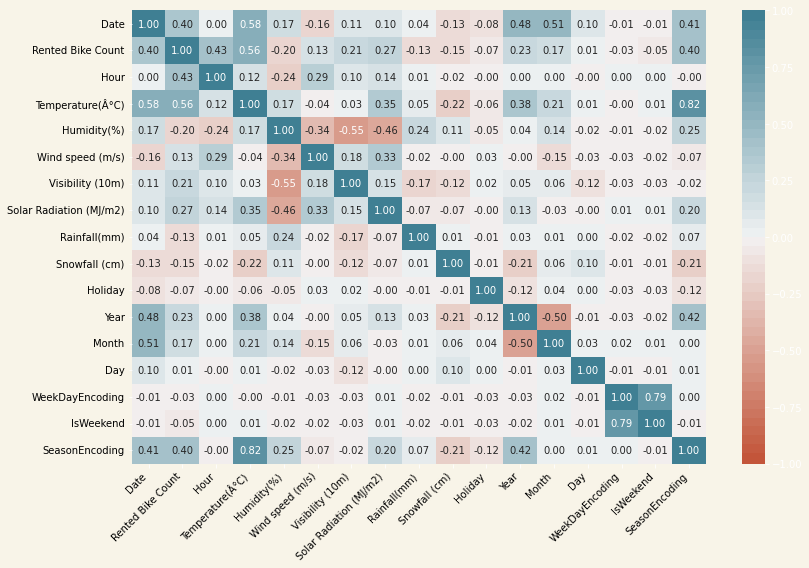

In [260]:
data_plot = work.drop(['WeekDay'], axis=1)

mapping_dictDay = {'Winter': 0,'Autumn': 1,'Spring': 2,'Summer': 3}
data_plot['SeasonEncoding'] = data_plot['Seasons'].map(mapping_dictDay)
data_plot.drop('Seasons', inplace=True, axis=1)

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#f8f4e8')
ax = sns.heatmap(data_plot.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=50), annot=True, fmt='.2f')
ax.set_xticklabels(labels=data_plot.columns, rotation=45, horizontalalignment='right', color='black')
ax.set_yticklabels(labels=data_plot.columns, color='black')
ax.set_facecolor('white')
plt.tight_layout()
plt.show

Considerable correlations with our target: Date, Hour, Temperature and Seasons


In [261]:
data_plot.corr()['Rented Bike Count'].nsmallest(n=10)

Humidity(%)        -0.201973
Snowfall (cm)      -0.151611
Rainfall(mm)       -0.128626
Holiday            -0.070070
IsWeekend          -0.046360
WeekDayEncoding    -0.034272
Day                 0.007644
Wind speed (m/s)    0.125022
Month               0.167186
Visibility (10m)    0.212323
Name: Rented Bike Count, dtype: float64

## Trends over the Year
This section dives into the big picture, examining trends and patterns across the entire year, identifying seasonal variations and overall performance.

Let's group the dates and calculate: temperature mean, sum of rented bikes and the modes for season, weekday, month and day.

In [280]:
data_plot = work[['Date', 'Temperature(Â°C)', 'Humidity(%)', 'Rainfall(mm)', 'Rented Bike Count', 'Seasons', 'WeekDay', 'Month', 'Day']].groupby('Date', axis=0).agg(
    {
        'Temperature(Â°C)': lambda x: x.mean(),
        'Humidity(%)': lambda x: x.mean(),
        'Rented Bike Count': lambda x: x.sum(),
        'Rainfall(mm)': lambda x: x.sum(),
        'Seasons': lambda x: x.mode(),
        'WeekDay': lambda x: x.mode(),
        'Month': lambda x: x.mode(),
        'Day': lambda x: x.mode()
    }
)
data_plot = data_plot.reset_index()
data_plot

,Date,Temperature(Â°C),Humidity(%),Rented Bike Count,Rainfall(mm),Seasons,WeekDay,Month,Day
0,2017-12-01,-2.454167,45.875000,9539,0.0,Winter,Friday,12,1
1,2017-12-02,1.325000,61.958333,8523,0.0,Winter,Saturday,12,2
2,2017-12-03,4.875000,81.541667,7222,4.0,Winter,Sunday,12,3
3,2017-12-04,-0.304167,52.500000,8729,0.1,Winter,Monday,12,4
4,2017-12-05,-4.458333,36.416667,8307,0.0,Winter,Tuesday,12,5
...,...,...,...,...,...,...,...,...,...
348,2018-11-26,6.320833,70.500000,17162,0.0,Autumn,Monday,11,26
349,2018-11-27,7.066667,68.000000,16282,0.0,Autumn,Tuesday,11,27
350,2018-11-28,5.304167,25.791667,16524,0.0,Autumn,Wednesday,11,28
351,2018-11-29,3.304167,38.000000,16423,0.0,Autumn,Thursday,11,29


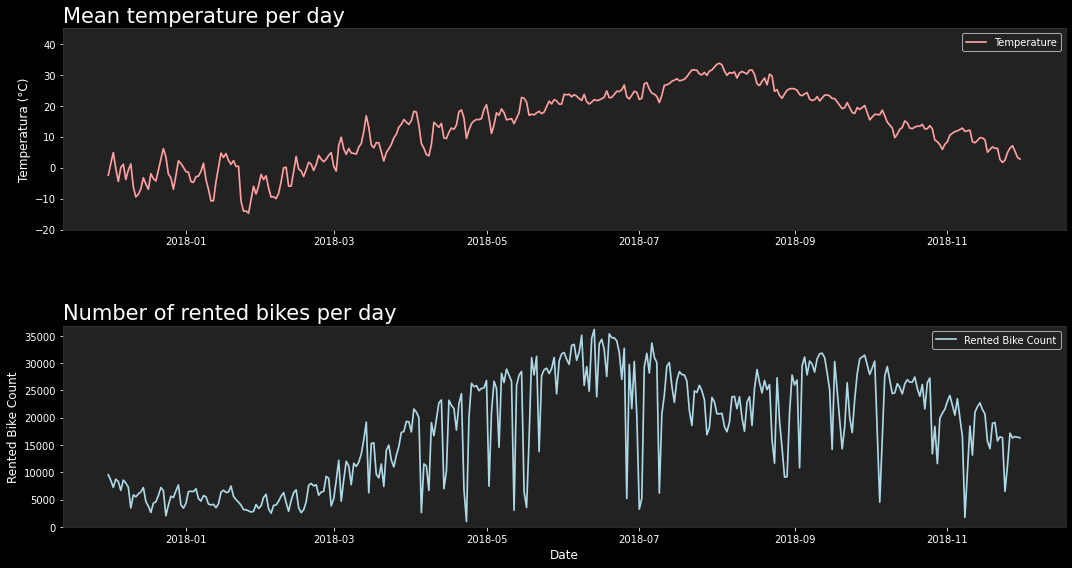

In [289]:
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#222222'
plt.rcParams['axes.edgecolor'] = '#333333'

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot temperature data
ax1.plot(data_plot['Date'], data_plot['Temperature(Â°C)'], color='#ffa0a0', label='Temperature', linewidth=1.7)
ax1.set_ylabel('Temperatura (°C)', size=12)
ax1.set_ylim(-20, 45)
ax1.set_title('Mean temperature per day', fontsize=21, loc='left')
ax1.legend()

# Plot rented bike count data
ax2.plot(data_plot['Date'], data_plot['Rented Bike Count'], color='lightblue', label='Rented Bike Count', linewidth=1.7)
ax2.set_ylabel('Rented Bike Count', size=12)
ax2.set_ylim(0, np.max(data_plot['Rented Bike Count'])+700)
ax2.set_xlabel('Date', size=12)
ax2.set_title('  \n\nNumber of rented bikes per day', fontsize=21, loc='left')
ax2.legend()

'''# Plot rented bike count data
ax3.plot(data_plot['Date'], data_plot['Rainfall(mm)'], color='lightblue', label='Rented Bike Count', linewidth=1.7)
ax3.set_ylabel('Rented Bike Count', size=12)
#ax3.set_ylim(0, np.max(data_plot['Rented Bike Count'])+700)
ax3.set_xlabel('Date', size=12)
ax3.set_title('  \n\nNumber of rented bikes per day', fontsize=21, loc='left')
ax3.legend()'''

# Overall figure adjustments
plt.tight_layout()

# Show the plot
plt.show()


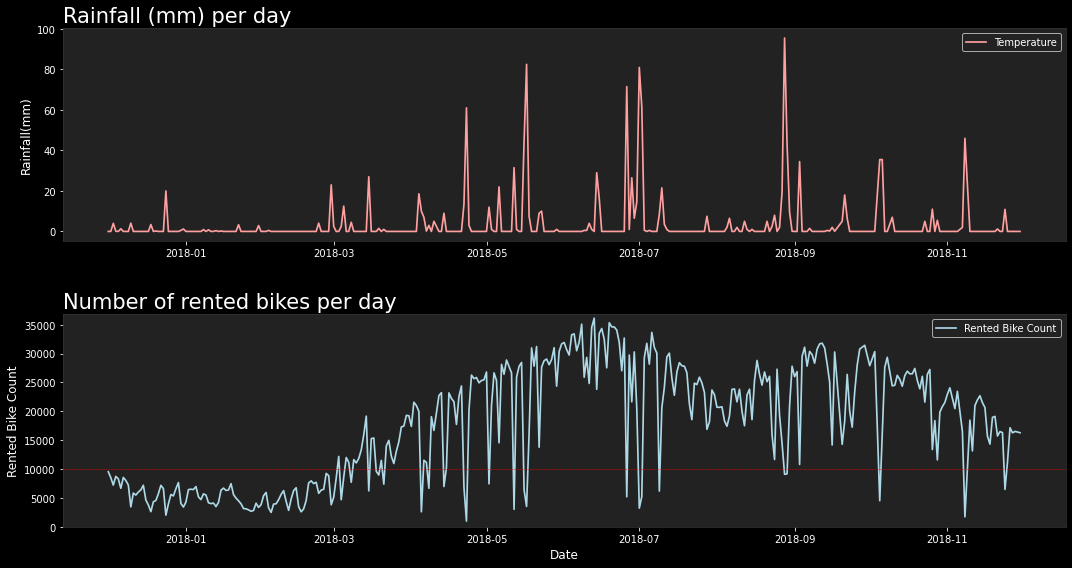

In [303]:
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#222222'
plt.rcParams['axes.edgecolor'] = '#333333'

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot temperature data
ax1.plot(data_plot['Date'], data_plot['Rainfall(mm)'], color='#ffa0a0', label='Temperature', linewidth=1.7)
ax1.set_ylabel('Rainfall(mm)', size=12)
ax1.set_title('Rainfall (mm) per day', fontsize=21, loc='left')
ax1.legend()

# Plot rented bike count data
ax2.plot(data_plot['Date'], data_plot['Rented Bike Count'], color='lightblue', label='Rented Bike Count', linewidth=1.7)
ax2.set_ylabel('Rented Bike Count', size=12)
ax2.set_ylim(0, np.max(data_plot['Rented Bike Count'])+700)
ax2.set_xlabel('Date', size=12)
ax2.set_title('  \nNumber of rented bikes per day', fontsize=21, loc='left')
plt.axhline(y=10000, color='r', linestyle='--', linewidth=0.5)
ax2.legend()

'''# Plot rented bike count data
ax3.plot(data_plot['Date'], data_plot['Rainfall(mm)'], color='lightblue', label='Rented Bike Count', linewidth=1.7)
ax3.set_ylabel('Rented Bike Count', size=12)
#ax3.set_ylim(0, np.max(data_plot['Rented Bike Count'])+700)
ax3.set_xlabel('Date', size=12)
ax3.set_title('  Number of rented bikes per day', fontsize=21, loc='left')
ax3.legend()'''

# Overall figure adjustments
plt.tight_layout()

# Show the plot
plt.show()

Anomalies in bike rental data reveal days with substantially lower usage compared to the overall trend. Let's take a look:

In [326]:
date_list = data_plot[(data_plot['Date'] > '2018-03-01') & (data_plot['Rented Bike Count'] < 10000)]['Date'].to_list()

# Filter 'df' based on the converted date list and the 'Rented Bike Count' condition
filtered_df = work[work['Date'].isin(date_list)].reset_index(drop=True)
filtered_df.head()


,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Year,Month,Day,WeekDay,WeekDayEncoding,IsWeekend
0,2018-03-02,156,0,-4.3,53,2.6,1334,0.0,0.0,0.0,Spring,0,2018,3,2,Friday,5,0
1,2018-03-02,108,1,-4.6,52,2.1,1372,0.0,0.0,0.0,Spring,0,2018,3,2,Friday,5,0
2,2018-03-02,71,2,-5.3,52,1.2,1434,0.0,0.0,0.0,Spring,0,2018,3,2,Friday,5,0
3,2018-03-02,49,3,-5.7,50,1.7,1559,0.0,0.0,0.0,Spring,0,2018,3,2,Friday,5,0
4,2018-03-02,47,4,-5.8,48,1.5,1552,0.0,0.0,0.0,Spring,0,2018,3,2,Friday,5,0


In [295]:
work.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8465.0,729.156999,642.351166,2.0,214.0,542.00,1084.00,3556.00
Hour,8465.0,11.507029,6.920899,0.0,6.0,12.00,18.00,23.00
Temperature(Â°C),8465.0,12.771057,12.104375,-17.8,3.0,13.50,22.70,39.40
Humidity(%),8465.0,58.147194,20.484839,0.0,42.0,57.00,74.00,98.00
Wind speed (m/s),8465.0,1.725883,1.034281,0.0,0.9,1.50,2.30,7.40
Visibility (10m),8465.0,1433.873479,609.051229,27.0,935.0,1690.00,2000.00,2000.00
Solar Radiation (MJ/m2),8465.0,0.567868,0.868245,0.0,0.0,0.01,0.93,3.52
Rainfall(mm),8465.0,0.149120,1.125540,0.0,0.0,0.00,0.00,35.00
Snowfall (cm),8465.0,0.077685,0.444063,0.0,0.0,0.00,0.00,8.80
Holiday,8465.0,0.048198,0.214198,0.0,0.0,0.00,0.00,1.00


In [296]:
filtered_df.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,624.0,251.546474,265.598312,2.0,43.000,151.5,398.000,1841.00
Hour,624.0,11.500000,6.927740,0.0,5.750,11.5,17.250,23.00
Temperature(Â°C),624.0,13.061538,7.890197,-6.6,7.275,11.8,20.825,27.40
Humidity(%),624.0,78.677885,21.074288,21.0,64.000,88.0,96.000,98.00
Wind speed (m/s),624.0,1.634135,0.952485,0.0,0.900,1.5,2.200,5.00
Visibility (10m),624.0,1098.793269,692.259912,33.0,453.000,957.0,1922.500,2000.00
Solar Radiation (MJ/m2),624.0,0.196282,0.404478,0.0,0.000,0.0,0.230,2.83
Rainfall(mm),624.0,1.233013,3.383057,0.0,0.000,0.0,1.000,35.00
Snowfall (cm),624.0,0.126122,0.829419,0.0,0.000,0.0,0.000,8.80
Holiday,624.0,0.000000,0.000000,0.0,0.000,0.0,0.000,0.00


As we can see, the days with lower bike rental are, in general:
- more humid
- lower solar radiation
- rainy and snowy days

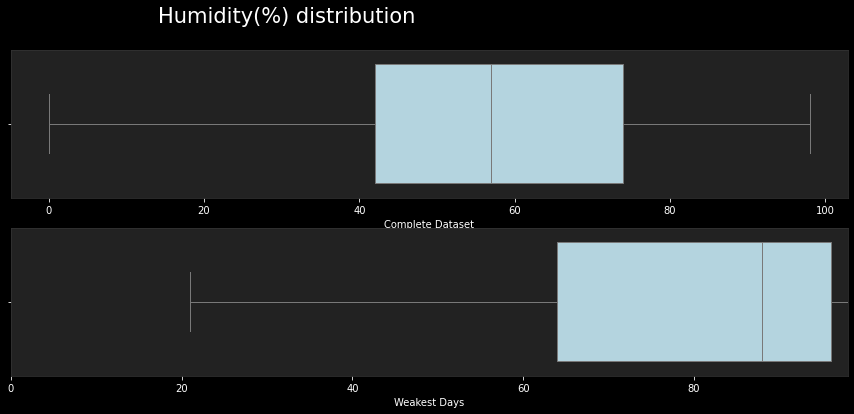

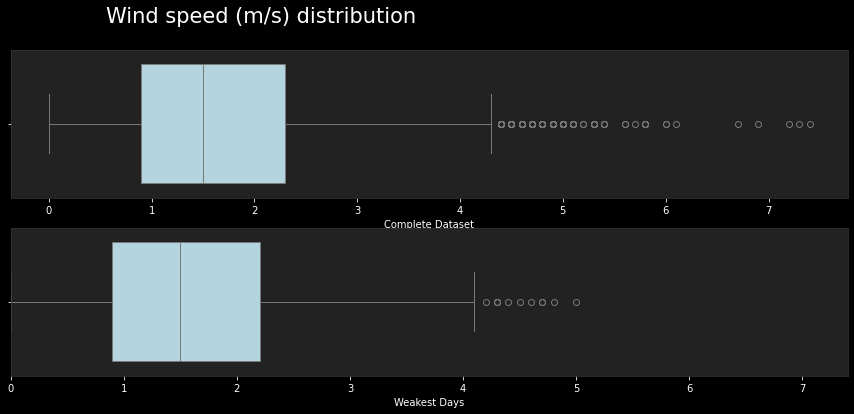

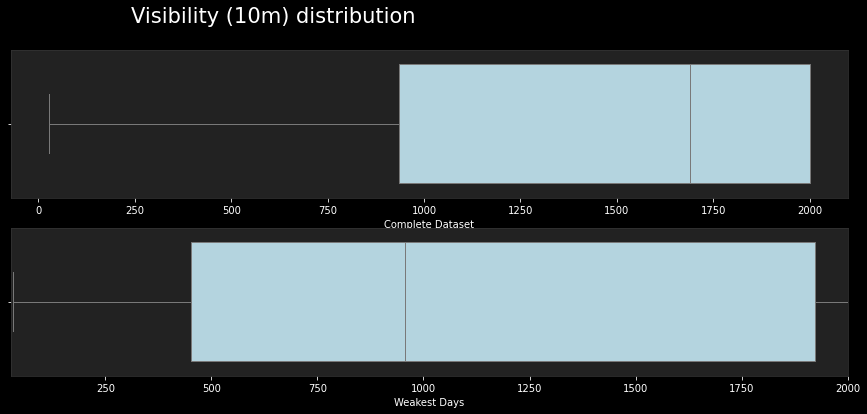

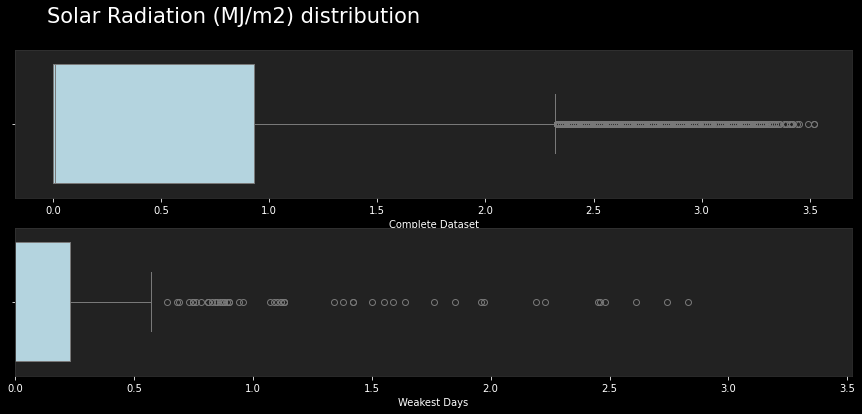

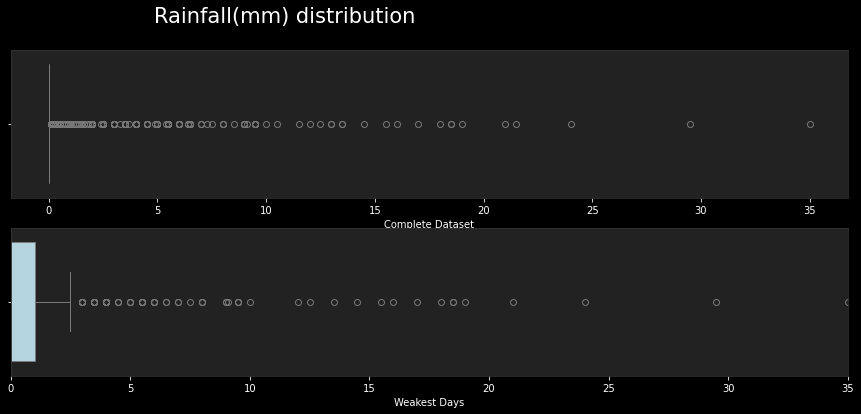

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_boxplots(df1, df2, cols):
  """
  Plots boxplots comparing the same columns from two DataFrames.

  Args:
      df1: First DataFrame.
      df2: Second DataFrame.
      cols: List of column names to compare.
  """
  for i, col in enumerate(cols):
    df3 = pd.concat([df1[col], df2[col]], axis=1, keys=['Complete Dataset', 'Weakest Days'])
    fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    plt.suptitle(f'{col} distribution', ha='right', fontsize=21)
    for idx, v in enumerate(df3.columns):
      sns.boxplot(data=df3[v], orient='h', ax=ax[idx], color='lightblue')
      plt.xlim(df1[col].min(), df1[col].max())
  plt.show()

# List of column names
cols = ['Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
        'Solar Radiation (MJ/m2)', 'Rainfall(mm)']

# Call the function to plot the boxplots
compare_boxplots(work, filtered_df, cols)


Let's see how it went monthly

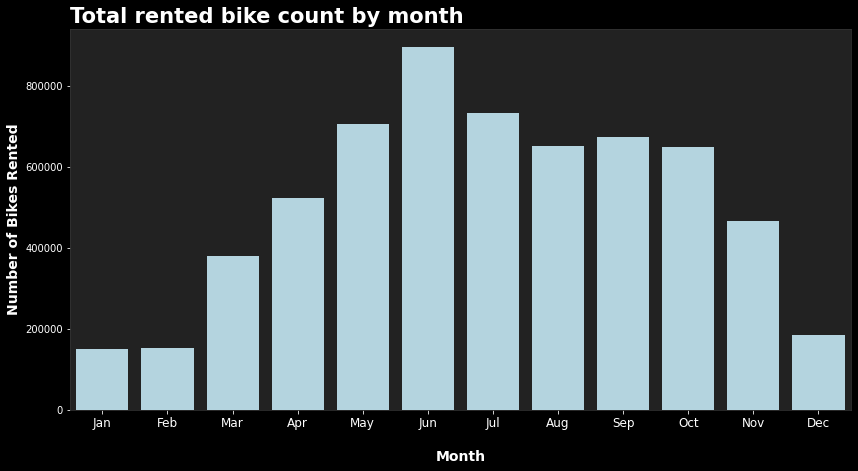

In [362]:
plt.figure(figsize=(14, 7))  

sns.barplot(data=data_plot.groupby('Month')['Rented Bike Count'].sum().reset_index(), 
            x='Month', y='Rented Bike Count', color='lightblue')

plt.title('Total rented bike count by month', loc='left', fontsize=21, fontweight='bold')  
plt.xlabel('\nMonth', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Bikes Rented', fontsize=14, fontweight='bold') 
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           fontsize=12)
 


plt.show() 

Rental numbers plummet in January, February, and December, lagging far behind the rest of the year.<br>Interestingly, this months fails to reach even 50% of March's rentals, which ranks as the fourth-worst month.<br>This likely occurs due to Seoul's harsh winter conditions during these months.<br><br>In the other hand, June is by far the peak of bike rental in Seoul. We can believe this happen because of the pleasant weather, longer daylight hours (reaching up to 15 hours a day), school holidays and it is known to be a good month to visit the city, so it is full of tourists, events and festivals

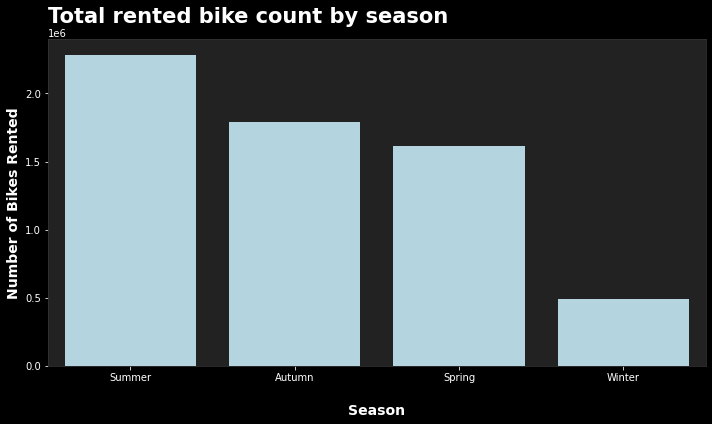

In [370]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data_plot.groupby('Seasons')['Rented Bike Count'].sum().reset_index().sort_values('Rented Bike Count', ascending=False),
            x='Seasons', y='Rented Bike Count', color='lightblue')

plt.title('Total rented bike count by season', loc='left', fontsize=21, fontweight='bold')  
plt.xlabel('\nSeason', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Bikes Rented', fontsize=14, fontweight='bold') 
plt.tight_layout()
plt.show()

Consistent with seasonal expectations, Seoul's bicycle rental data reveals a pronounced peak in summer, culminating in June's exceptional performance. Conversely, winter months demonstrate a significant decline in rental activity.

## Trends along the month
This section delves into the intricate patterns of bike rentals across a typical month and its weeks. 

In [163]:
# Lets order the days in the natural order for a better visualization
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

data_plot['WeekDay'] = pd.Categorical(data_plot['WeekDay'], categories=weekday_order, ordered=True)
data_plot = data_plot.sort_values('WeekDay')

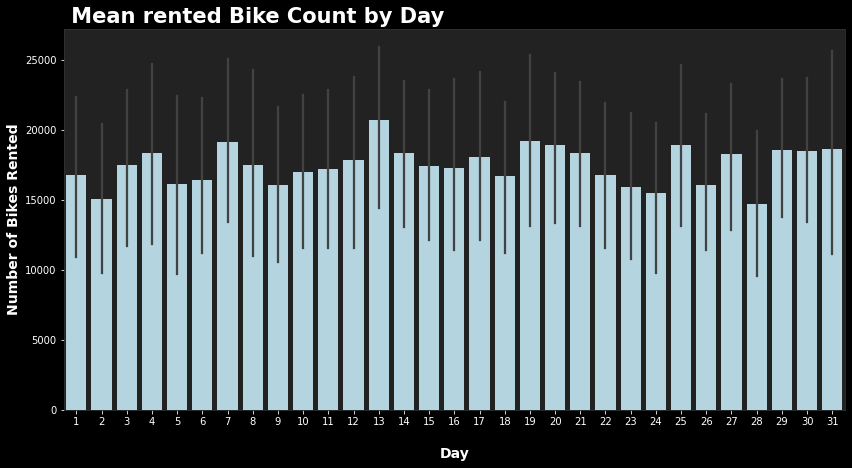

In [372]:
plt.figure(figsize=(14, 7))  

sns.barplot(data=data_plot, x='Day', y='Rented Bike Count', color='lightblue')

plt.title(' Mean rented Bike Count by Day', loc='left', fontsize=21, fontweight='bold')  
plt.xlabel('\nDay', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Bikes Rented', fontsize=14, fontweight='bold')  


plt.show() 

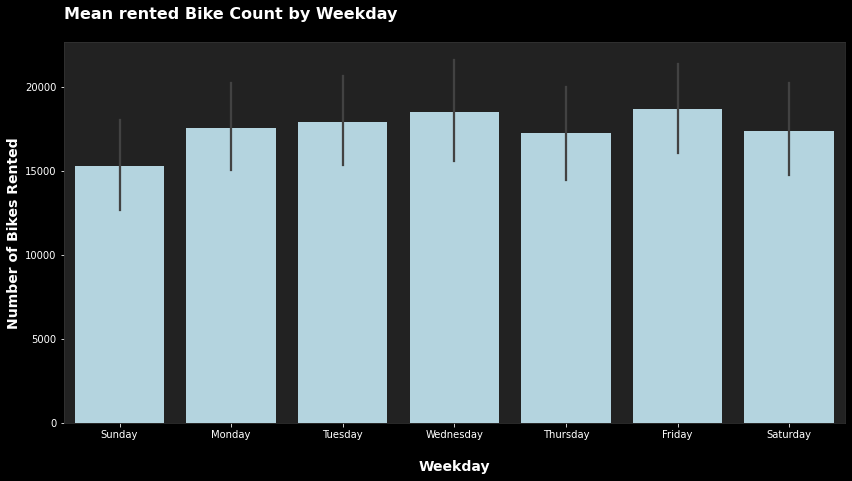

In [165]:
plt.figure(figsize=(14, 7))  

sns.barplot(data=data_plot, x='WeekDay', y='Rented Bike Count', color='lightblue')

plt.title('Mean rented Bike Count by Weekday\n', loc='left', fontsize=16, fontweight='bold')  
plt.xlabel('\nWeekday', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Bikes Rented', fontsize=14, fontweight='bold')  


plt.show() 


Bike rentals generally trend lower on weekends than weekdays, with Sunday seeing the least activity. Wednesdays and Fridays reign supreme with bike rentals, while Thursdays see a slight lull. Though the difference isn't dramatic, it hints at potential work schedules influencing weekday usage patterns.


### Hourly Analysis

Text(0, 0.5, 'Number of Bikes Rented')

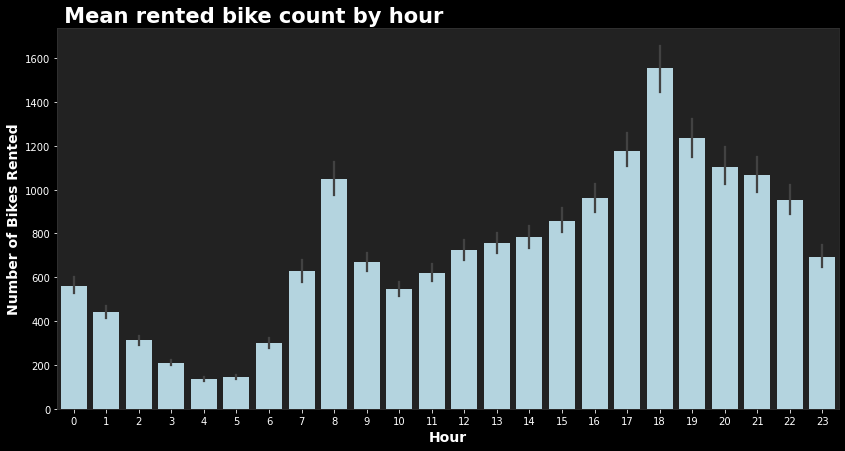

In [375]:
plt.figure(figsize=(14, 7))  
sns.barplot(data=work, x='Hour', y='Rented Bike Count', color='lightblue')

plt.title(' Mean rented bike count by hour', loc='left', fontsize=21, fontweight='bold')  
plt.xlabel('Hour', fontsize=14, fontweight='bold')  
plt.ylabel('Number of Bikes Rented', fontsize=14, fontweight='bold')  


Data reveals a clear morning peak at 8 AM and a significant afternoon surge from 4 PM to 10 PM, culminating in a pronounced high at 6 PM. This pattern aligns with our hypothesis, suggesting a dominant role of bike rentals in Seoul's commute, particularly for leaving work.

In [167]:
work.nlargest(n=50, columns=['Rented Bike Count'])['Hour'].value_counts()

Hour
18    45
19     5
Name: count, dtype: int64

## EDA for feature engineering

In [168]:
skewness = work.select_dtypes(include=[np.number]).skew()
print(skewness)

Rented Bike Count           1.139700
Hour                       -0.001261
Temperature(Â°C)           -0.174550
Humidity(%)                 0.068649
Wind speed (m/s)            0.894222
Visibility (10m)           -0.695306
Solar Radiation (MJ/m2)     1.510065
Rainfall(mm)               14.616921
Snowfall (cm)               8.292830
Holiday                     4.219538
Year                       -2.911538
Month                       0.034041
Day                        -0.018521
WeekDayEncoding            -0.015989
IsWeekend                   0.934539
dtype: float64


In [169]:
threshold = 0.5
skewed_features = skewness[abs(skewness) > threshold]
skewed_features

Rented Bike Count           1.139700
Wind speed (m/s)            0.894222
Visibility (10m)           -0.695306
Solar Radiation (MJ/m2)     1.510065
Rainfall(mm)               14.616921
Snowfall (cm)               8.292830
Holiday                     4.219538
Year                       -2.911538
IsWeekend                   0.934539
dtype: float64

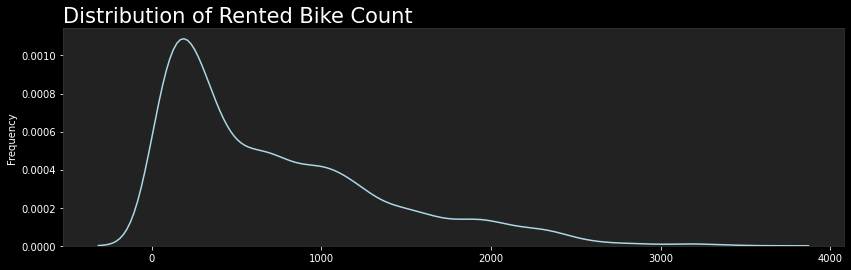

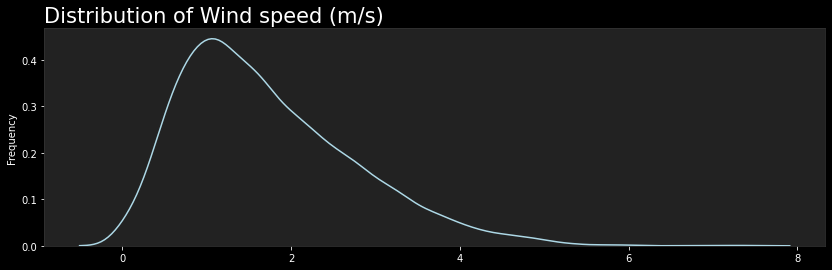

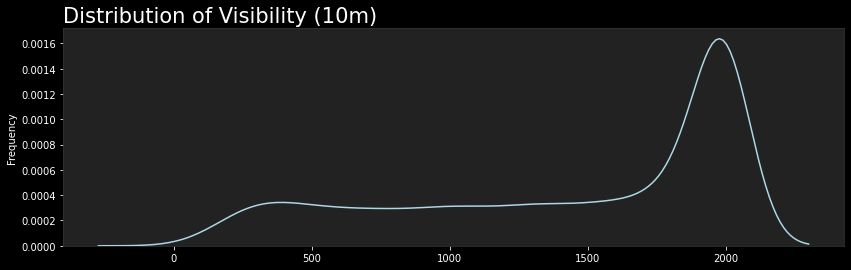

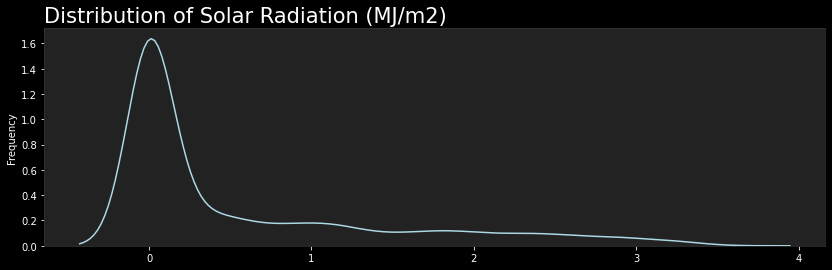

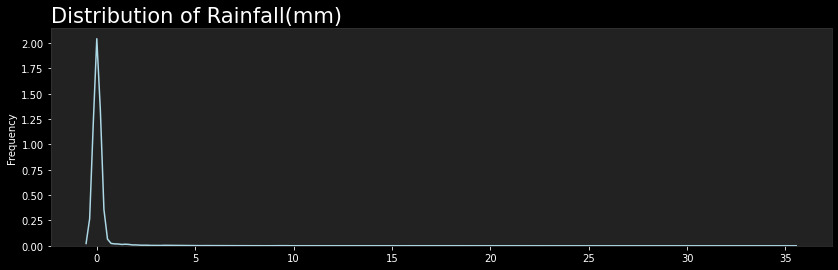

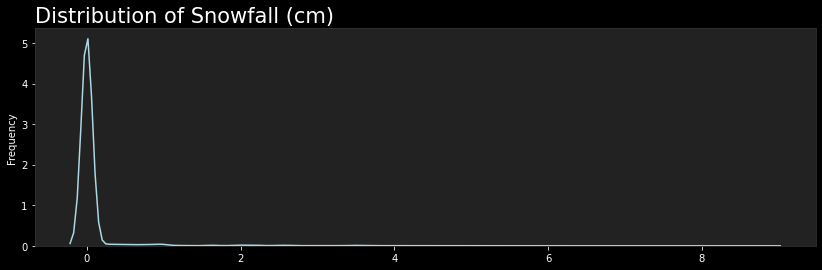

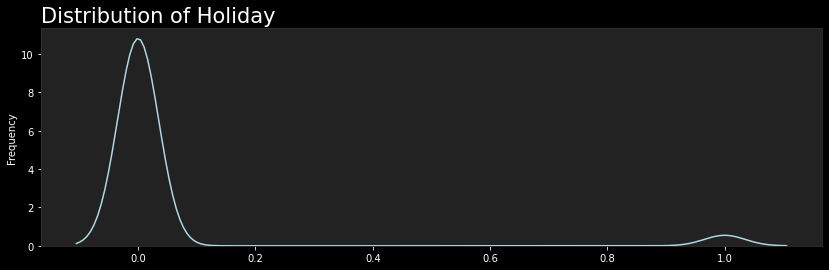

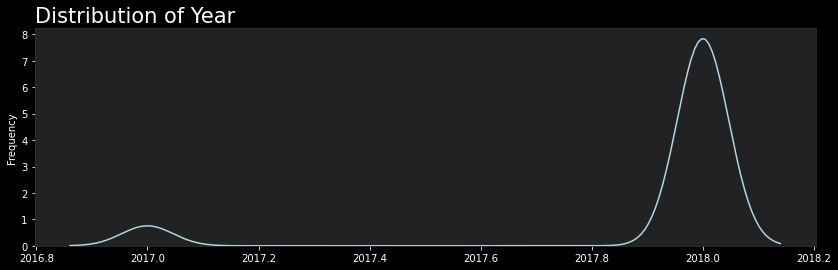

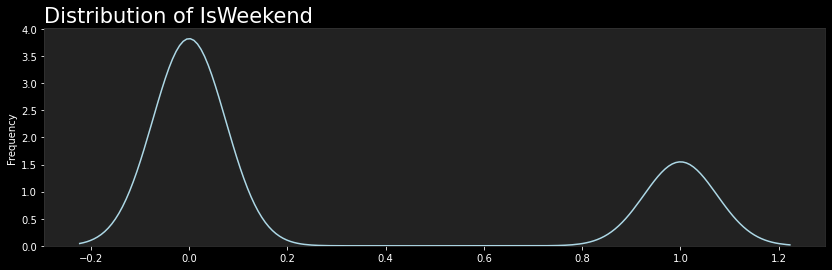

In [392]:
# Plot the distribution of skewed features
for feature in skewed_features.index:
    plt.figure(figsize=(14, 4))
    sns.kdeplot(work[feature], color='lightblue')
    plt.title(f'Distribution of {feature}', fontsize=21, loc='left')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()


### Rented Bike Count

Text(0.0, 1.0, 'Transformed Rented Bike Count Distribution')

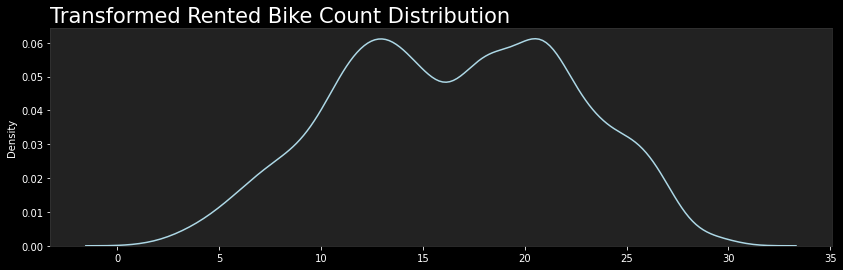

In [390]:
import scipy.stats as stats
from scipy.stats import yeojohnson

transformed_data, lambda_ = yeojohnson(work['Rented Bike Count'])

plt.figure(figsize=(14, 4))
sns.kdeplot(transformed_data, color='lightblue')
plt.title('Transformed Rented Bike Count Distribution', fontsize=21, loc='left')



In [173]:
work['Rented Bike Count'] = transformed_data

### Wind speed (m/s) 

0.0008351768531430066


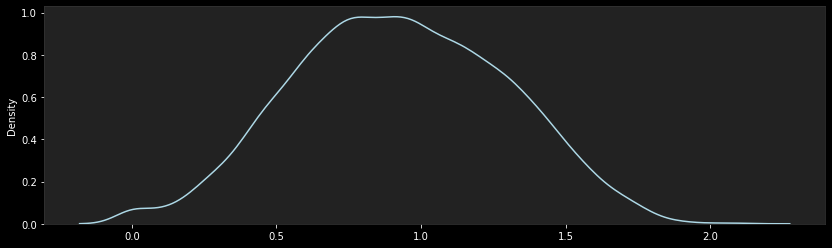

In [174]:
transformed_data, lambda_ = yeojohnson(work['Wind speed (m/s)'])

plt.figure(figsize=(14, 4))
sns.kdeplot(transformed_data, color='lightblue')

print(stats.skew(transformed_data))

In [175]:
work['Wind speed (m/s)'] = transformed_data

In [249]:
work.to_csv('../data/processed/SeoulDataTransf.csv')
